In [1]:
import argparse
import os
import torchvision
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display_html

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)


Random Seed:  999


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [01:26<00:00, 21.2MB/s]
100% 1.82G/1.82G [01:26<00:00, 22.7MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/stanford-cars-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
class Dataset(Dataset):

  def __init__(self, path_of_data):

    super(Dataset, self).__init__()

    transform_ds = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    self.images = torchvision.datasets.ImageFolder(root = path_of_data, transform = transform_ds)


  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    return self.images[index]

dataset = Dataset('/content/cars_train')

"""dataset = dset.ImageFolder(root="/content/cars_train/cars_train",
                           transform=transforms.Compose([
                               transforms.Resize(64),

                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

"""

'dataset = dset.ImageFolder(root="/content/cars_train/cars_train",\n                           transform=transforms.Compose([\n                               transforms.Resize(64),\n                              \n                               transforms.ToTensor(),\n                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\n                           ]))\n# Create the dataloader\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,\n                                         shuffle=True, num_workers=workers)\n\n'

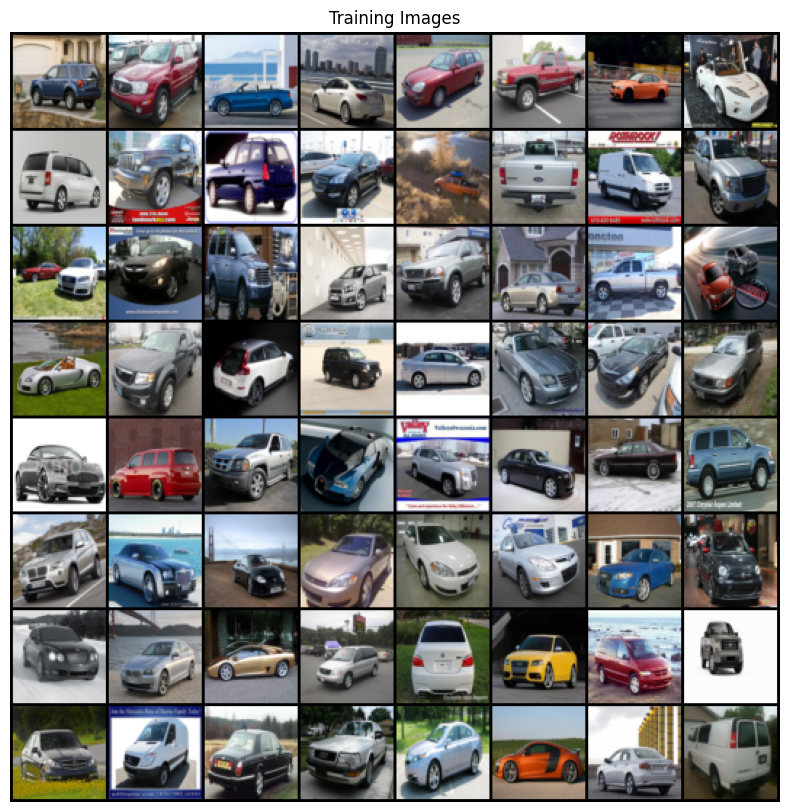

In [8]:
dataloader = DataLoader(
    dataset,
    batch_size = 128,
    shuffle = True
)

real_batch = next(iter(dataloader))
plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding = 2, normalize = True), (1,2,0)))



In [9]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [10]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!= -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm')!= -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data,0)

In [12]:
from torch.nn.modules.conv import ConvTranspose2d
ngf =64
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( 100, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [13]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [15]:
ndf = 64
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(62, 100,1,1, device = device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5,0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))

In [25]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(50):

  for i, data in enumerate(dataloader,0):

    netD.zero_grad()
    real_cpu  = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
    output = netD(real_cpu).view(-1)
    errD_real = criterion(output,label)
    errD_real.backward()
    D_x = output.mean().item()


    noise = torch.randn(b_size, 100, 1,1, device = device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    errD = errD_real = errD_fake
    optimizerD.step()


    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()


    print('[%d/50][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if iters%50 ==0:
      with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters+=1

    G_losses.append(errG.item())
    D_losses.append(errD.item())







[0/50][0/64]	Loss_D: 0.2114	Loss_G: 4.6152	D(x): 0.9283	D(G(z)): 0.1753 / 0.0156
[0/50][1/64]	Loss_D: 0.0345	Loss_G: 2.8413	D(x): 0.7825	D(G(z)): 0.0330 / 0.0980
[0/50][2/64]	Loss_D: 0.2600	Loss_G: 3.8535	D(x): 0.9388	D(G(z)): 0.2093 / 0.0312
[0/50][3/64]	Loss_D: 0.0958	Loss_G: 3.5509	D(x): 0.8604	D(G(z)): 0.0858 / 0.0465
[0/50][4/64]	Loss_D: 0.1105	Loss_G: 2.9206	D(x): 0.8718	D(G(z)): 0.1001 / 0.0773
[0/50][5/64]	Loss_D: 0.2077	Loss_G: 4.4329	D(x): 0.9168	D(G(z)): 0.1738 / 0.0177
[0/50][6/64]	Loss_D: 0.0714	Loss_G: 2.9739	D(x): 0.7997	D(G(z)): 0.0652 / 0.0868
[0/50][7/64]	Loss_D: 0.1785	Loss_G: 3.0206	D(x): 0.8761	D(G(z)): 0.1443 / 0.0714
[0/50][8/64]	Loss_D: 0.1813	Loss_G: 4.6565	D(x): 0.9460	D(G(z)): 0.1503 / 0.0154
[0/50][9/64]	Loss_D: 0.0705	Loss_G: 2.5578	D(x): 0.7657	D(G(z)): 0.0640 / 0.1231
[0/50][10/64]	Loss_D: 0.3206	Loss_G: 5.1250	D(x): 0.9704	D(G(z)): 0.2459 / 0.0088
[0/50][11/64]	Loss_D: 0.0676	Loss_G: 2.9671	D(x): 0.7381	D(G(z)): 0.0579 / 0.0945
[0/50][12/64]	Loss_D: 0.18

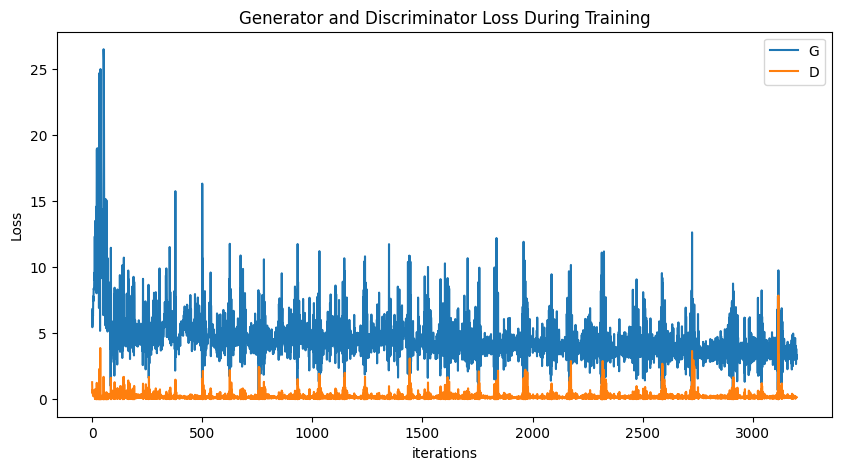

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

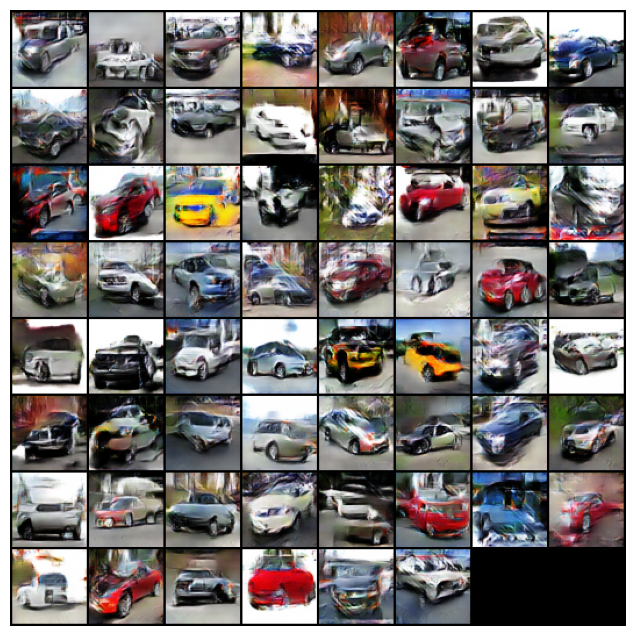

In [59]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list1]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

ani.save('movie.mp4')

In [28]:
img_list1 = img1 + img_list